In [6]:
"""initial particle distribution(uniform or Gaussian around init GPS)"""
def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def systematic_resample(weights):
    N = len(weights)

    # make N subdivisions, choose positions with a consistent random offset
    positions = (np.arange(N) + random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def neff(weights):
    return 1. / np.sum(np.square(weights))

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

In [7]:
from scipy.stats import multivariate_normal

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist
    
def update(particles, weights, z, R, landmarks):
    """weighting by iid mulvivariate Gaussian density
    with covs 0, is product of prob. of each dimensional variable"""
    N = len(particles)
    
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
        
    weights += 1.e-300
    tot_weights = sum(weights)
    weights /= sum(weights) # normalize
        
    return weights

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def predict_with_acc_try(acc,particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += (u[0] + acc[:,0]*(dt**2)/2 + (randn(N) * std[0]))
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = acc[:,1]*(dt**2)/2 + (randn(N) * std[0])
    particles[:, 0] += (np.cos(particles[:, 2]) * (u[1] * dt) + np.cos(particles[:, 2]) * dist)
    particles[:, 1] += (np.sin(particles[:, 2]) * (u[1] * dt) + np.sin(particles[:, 2]) * dist)

def predict_with_acc_mu(acc,particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += (u[0] + acc[0]*(dt**2)/2 + (randn(N) * std[0]))
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = acc[1]*(dt**2)/2 + (randn(N) * std[0])
    particles[:, 0] += (np.cos(particles[:, 2]) * (u[1] * dt) + np.cos(particles[:, 2]) * dist)
    particles[:, 1] += (np.sin(particles[:, 2]) * (u[1] * dt) + np.sin(particles[:, 2]) * dist)


def fobj(a, solution, particles, u, std, z, R, landmarks, dt=1.):
    N = len(particles)
    
    weights = np.ones(N) / N
    predict_with_acc_try(a, particles, u=(0.00, 1.414), std=(.2, .05))
    weights = update(particles, weights, z, R, landmarks)

    #return -1.*np.square(solution - weights)
    return np.square(solution - weights)

def estimate_a(a):
    """returns mean and variance of the weighted particles"""
    mean = np.average(a, axis=0)
    var  = np.average((a - mean)**2)
    return mean, var

In [8]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf361(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([0., 0.])
    
    #for evolutionary filters
    npop = len(particles)
    a = [0.0, np.random.randn()] # angular acc. = 0.0, linear acc =randn()
    #a = [0.0, 0.0] # angular acc. = 0.0, linear acc =randn()
    sigma= 0.1
    lr= 0.1

    for x in range(iters):

        # distance from robot to each landmark
        #robot_pos += (log(1+x*0.8), log(1+x*0.8))
        robot_pos += (1+randn(), 1+randn())
        #robot_pos += (1+rand(), 1+rand())
        #robot_pos += (1, 1)
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.4, .1))
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

params: [0.0, 0.22864179504556809] errors: 0.14823068355425198
params: [0.0, 0.22864179504556809] errors: 0.2684639905367078
params: [0.0, 0.22864179504556809] errors: 0.057055111712812454
params: [0.0, 0.22864179504556809] errors: 0.15278322049603138
params: [0.0, 0.22864179504556809] errors: 0.22405683302772766
params: [0.0, 0.22864179504556809] errors: 0.03629046921534986
params: [0.0, 0.22864179504556809] errors: 0.08697321178912126
params: [0.0, 0.22864179504556809] errors: 0.1641727608770936
params: [0.0, 0.22864179504556809] errors: 0.15010697648529628
params: [0.0, 0.22864179504556809] errors: 0.09064803201532314
params: [0.0, 0.22864179504556809] errors: 0.944408980497176
params: [0.0, 0.22864179504556809] errors: 0.714158556122968
params: [0.0, 0.22864179504556809] errors: 0.28458465863416665
params: [0.0, 0.22864179504556809] errors: 0.06146380379854548
params: [0.0, 0.22864179504556809] errors: 0.12022285687275387
params: [0.0, 0.22864179504556809] errors: 1.302873528903518

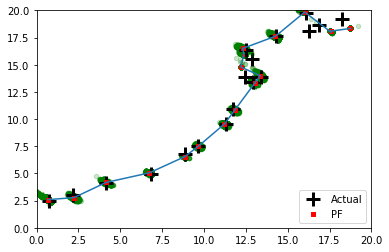

In [9]:
from numpy.random import seed
seed(2) 

run_pf361(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

# Adapting parameters

In [46]:
# from filterpy.monte_carlo import systematic_resample
import matplotlib.pyplot as plt
import numpy as np
from math import *
from numpy.linalg import norm
from numpy.random import randn
from numpy.random import *
import scipy.stats

def run_pf51(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
    
    xs, ps, errors = [], [], []
    robot_pos = np.array([0., 0.])
    
    #########################
    #for evolutionary filters
    npop = len(particles)

    a = [0.0, np.random.randn()] #angular acc.=0, linear acc. = mu 0, sig 1
    print("init. params:", a)
    sigma= 0.1
    lr= 0.1
    
    f = np.zeros(npop) 
    fitness = f
    #########################
    
    for x in range(iters):

        #robot_pos += (log(1+x), log(1+x))
        robot_pos += (1+randn(), 1+randn())
        #robot_pos += (1+rand(), 1+rand())
        #robot_pos += (1, 1)
        ps.append(robot_pos)
        
        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))
        
        #######################
        
        pop = np.random.randn(npop, 2)

        
        # acc. bound is -10~10
        min_b, max_b = np.asarray([(-1,1)]*2).T
        diff = np.fabs(min_b - max_b)
        pop_denorm = min_b + pop * diff

        
        idxs = np.random.randint(0,npop,size=(npop,3))
        abc = pop[idxs]
        mutant = np.clip(abc[:, 0] + .1 * (abc[:, 1] - abc[:, 2]), 0, 1)
        
        cross_points = np.random.rand(npop,2) < 0.7
        # ignore all dimensions False case
        trial = np.where(cross_points, mutant, pop)
        
        trial_denorm = min_b + trial * diff
        
        f = fobj(trial_denorm, weights, particles.copy(), u=(0.00, 1.414), std=(.4, .1), 
            z=zs, R=sensor_std_err, landmarks=landmarks, dt=1.)
        
        pop[f > fitness] = trial[f > fitness]
        fitness = f
        
        best_idx = fitness.argmin()
        best     = trial_denorm[best_idx]
        
        a = pop[best_idx]
                
        #######################
        
        predict_with_acc_mu(a, particles, u=(0.00, 1.414), std=(.4, .1))
        weights = update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)

        mu, var = estimate(particles, weights)
        xs.append(mu)
        
        errors.append(np.linalg.norm(robot_pos-mu))
        print("params:",a, "errors:",np.linalg.norm(robot_pos-mu))

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1],alpha=alpha, color='g', s=20)
            
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r', s = 10)
        
    xs = np.array(xs)
    plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    
    #MSE = 1./iters * sum((p - s)**2 for p, s in zip(ps, xs))
    #print("Mean Squared Error: \n\t {}".format(MSE))

    print("Sum of Error Norm: \n\t {}".format(np.sum(errors)))
    plt.show()

init. params: [0.0, 0.22864179504556809]
params: [-0.25572635  0.        ] errors: 0.06052111391244587
params: [-0.73928151 -0.55067488] errors: 0.2783929675713512
params: [-0.69166085  0.73877987] errors: 0.3276683328191634
params: [-0.05827303  2.30712199] errors: 0.008461976009113685
params: [1.04987543 0.50472701] errors: 0.1885161787333347
params: [1.27871082 2.42410125] errors: 0.10647389610225015
params: [-1.00299268  1.09319958] errors: 0.1222969622623153
params: [0.28987407 0.87761599] errors: 0.27153356718383204
params: [-0.41082587  1.10406047] errors: 0.4310094069431964
params: [-0.87514014  1.93201582] errors: 0.08836424967148283
params: [ 0.78333028 -0.69420093] errors: 0.05306106180064862
params: [-1.7640333  -0.49991297] errors: 0.3663235050515159
params: [-0.1900593   1.82389865] errors: 0.2173504845051152
params: [ 0.00550845 -0.79022023] errors: 0.3225747081312182
params: [ 0.01615192 -0.01480312] errors: 0.30532426322407724
params: [0.01363513 1.1411328 ] errors: 0.

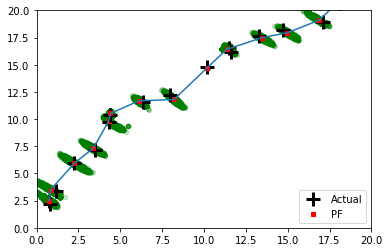

In [47]:
from numpy.random import seed
seed(2) 
#run_pf5(N=5000, plot_particles=True)
run_pf51(N=5000, plot_particles=True, initial_x=(1,1, np.pi/4))

In [51]:
((2/5)*(2/(21*21*7)))/((2/5)*(2/(21*21*7)) + ((3/5)*(4/(27*27*9))))

0.41467576791808874